In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from PIL import Image
from utils import show_images, preview_dataset

In [2]:
print("TensorFlow version:", tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Detected GPUs:", len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.5.0
Detected GPUs: 1


In [3]:
dataset_signature = tf.TensorSpec(shape=(256, 256, 3), dtype=tf.uint8)

In [4]:
np_synla_4096 = np.load("/hdd/sdb/SYNLA_Plus_4096.npy", mmap_mode='r')
images_synla_4096 = tf.data.Dataset.from_generator(lambda: np_synla_4096, output_signature=(dataset_signature))
print(len(np_synla_4096))

4096


In [5]:
np_synla_1024 = np.load("/hdd/sdb/SYNLA_Plus_1024.npy", mmap_mode='r')
images_synla_1024 = tf.data.Dataset.from_generator(lambda: np_synla_1024, output_signature=(dataset_signature))
print(len(np_synla_1024))

1024


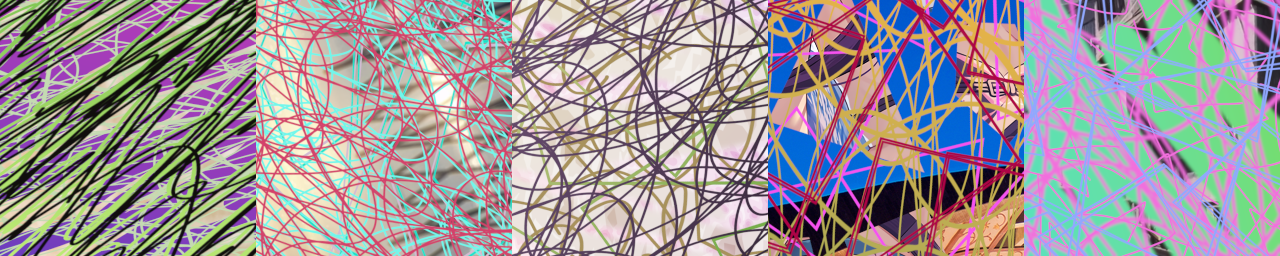

In [6]:
preview_dataset(images_synla_4096)

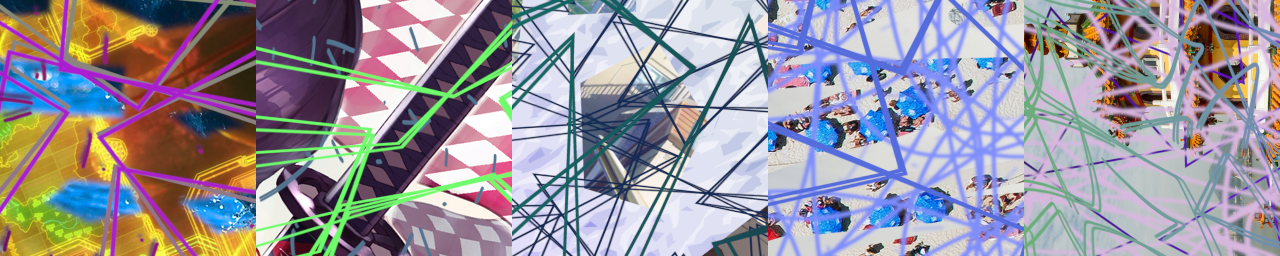

In [7]:
preview_dataset(images_synla_1024)

In [8]:
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K

#Modified depth_to_space shuffle order for easier shader generation
class DepthToSpace2(tf.keras.layers.Layer):
    def __init__(self, input_depth, **kwargs):
        super(DepthToSpace2, self).__init__(**kwargs)
        self.input_depth = input_depth

    def build(self, input_shape):
        super(DepthToSpace2, self).build(input_shape)

    def call(self, x):
        x = tf.split(x, (self.input_depth // 4), axis=-1)
        return tf.concat([tf.nn.depth_to_space(xx, 2) for xx in x], axis=-1)

#SR model that does not change image size
def SR1Model(input_depth=3, highway_depth=4, block_depth=4, init='he_normal', init_last = RandomNormal(mean=0.0, stddev=0.001)):

    input_shape = [None, None, input_depth]
    input_lr = tf.keras.layers.Input(shape=input_shape)
    
    depth_list = []
    
    x = input_lr
    for i in range(block_depth):
        x = tf.keras.layers.Conv2D(highway_depth, (3, 3), padding='same', kernel_initializer=init)(x)
        x = tf.nn.crelu(x)
        depth_list.append(x)

    x = tf.keras.layers.Concatenate(axis=-1)(depth_list)
    x = tf.keras.layers.Conv2D(input_depth, (1, 1), padding='same', kernel_initializer=init_last)(x)
    
    x = tf.keras.layers.Add()([x, input_lr])

    model = tf.keras.models.Model(input_lr, x)

    return model

#SR model that doubles image size
def SR2Model(input_depth=3, highway_depth=4, block_depth=4, init='he_normal', init_last = RandomNormal(mean=0.0, stddev=0.001)):

    input_shape = [None, None, input_depth]
    input_lr = tf.keras.layers.Input(shape=input_shape)
    input_lr2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(input_lr)
    
    depth_list = []
    
    x = input_lr
    for i in range(block_depth):
        x = tf.keras.layers.Conv2D(highway_depth, (3, 3), padding='same', kernel_initializer=init)(x)
        x = tf.nn.crelu(x)
        depth_list.append(x)

    x = tf.keras.layers.Concatenate(axis=-1)(depth_list)
    x = tf.keras.layers.Conv2D(4*input_depth, (1, 1), padding='same', kernel_initializer=init_last)(x)
    x = DepthToSpace2(4*input_depth)(x)
    
    x = tf.keras.layers.Add()([x, input_lr2])

    model = tf.keras.models.Model(input_lr, x)

    return model

In [9]:
K.reset_uids()
model = SR2Model(3, 4, block_depth=7)
model.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, None, None, 3)]          0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                  (None, None, None, 4)            112               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.compat.v1.nn.crelu (TFOpLambda)               (None, None, None, 8)         

In [10]:
from utils import degrade_ring, degrade_blur_gaussian, degrade_noise_gaussian, degrade_rgb_to_yuv, degrade_yuv_to_rgb

In [11]:
def augment_images(img):
    img = img / 255

    img = tf.image.random_hue(img, 0.5)
    img = tf.image.random_contrast(img, 0.5, 2.0)
    img = tf.clip_by_value(img, 0, 1)
    
    img = tf.image.random_flip_left_right(img)
    img = tf.image.rot90(img, k=tf.experimental.numpy.random.randint(4, dtype=tf.int32))

    if tf.random.uniform(shape=()) < 0.1:
        img = degrade_blur_gaussian(img, 1.0, shape=(5, 5))

    lr, hr = img, img

    if tf.random.uniform(shape=()) < 0.1:
        random_sigma = tf.random.uniform(shape=(), minval=2.0, maxval=5.0)
        lr = degrade_ring(lr, random_sigma, shape=(5, 5))

    if tf.random.uniform(shape=()) < 0.1:
        random_sigma = tf.random.uniform(shape=(), minval=0.1, maxval=0.5)
        lr = degrade_blur_gaussian(lr, random_sigma, shape=(3, 3))

    hr_shape = tf.shape(hr)
    if tf.random.uniform(shape=()) < 0.5:
        lr = tf.image.resize(lr, [hr_shape[-3]//2, hr_shape[-2]//2], method="area")
    else:
        lr = tf.image.resize(lr, [hr_shape[-3]//2, hr_shape[-2]//2], method="bicubic")

    if tf.random.uniform(shape=()) < 0.8:
        lr = degrade_rgb_to_yuv(lr, jpeg_factor=tf.experimental.numpy.random.randint(70, 90, dtype=tf.int32), chroma_subsampling=True, chroma_method="area")
        lr = degrade_yuv_to_rgb(lr, chroma_method="bicubic")
        #Process hr alongside with lr to prevent mean shift from jpeg and conversion errors
        hr = degrade_rgb_to_yuv(hr, jpeg_factor=95, chroma_subsampling=False)
        hr = degrade_yuv_to_rgb(hr)

    return lr, hr

def augment_images_valid(img):
    img = img / 255

    lr, hr = img, img
    
    hr_shape = tf.shape(hr)
    lr = tf.image.resize(lr, [hr_shape[-3]//2, hr_shape[-2]//2], method="area")

    return lr, hr

In [12]:
batch_size = 32

dataset_train = images_synla_4096
dataset_train = dataset_train.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.AUTOTUNE)

dataset_valid = images_synla_1024
dataset_valid = dataset_valid.map(augment_images_valid, num_parallel_calls=tf.data.AUTOTUNE)
dataset_valid = dataset_valid.batch(batch_size)
dataset_valid = dataset_valid.prefetch(tf.data.AUTOTUNE)

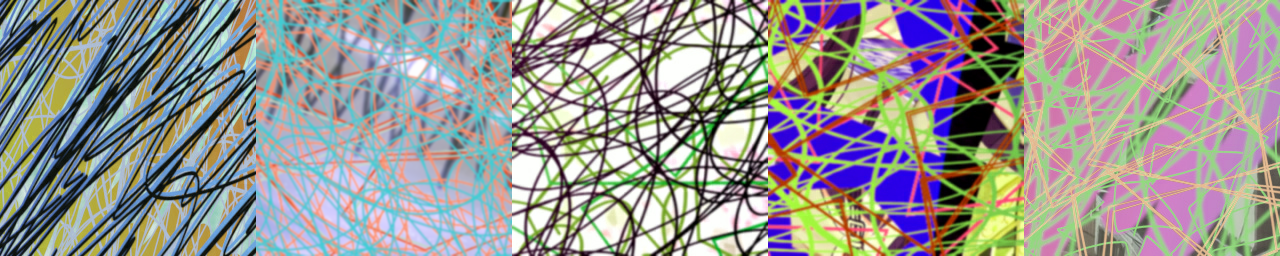

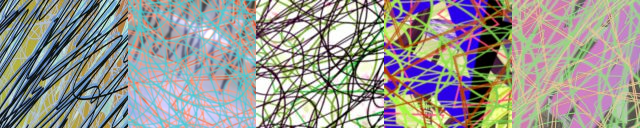

In [13]:
d_pred = next(iter(dataset_train))
show_images(d_pred[1], val_range=[0, 1], scale=4)
show_images(d_pred[0], val_range=[0, 1], scale=8)

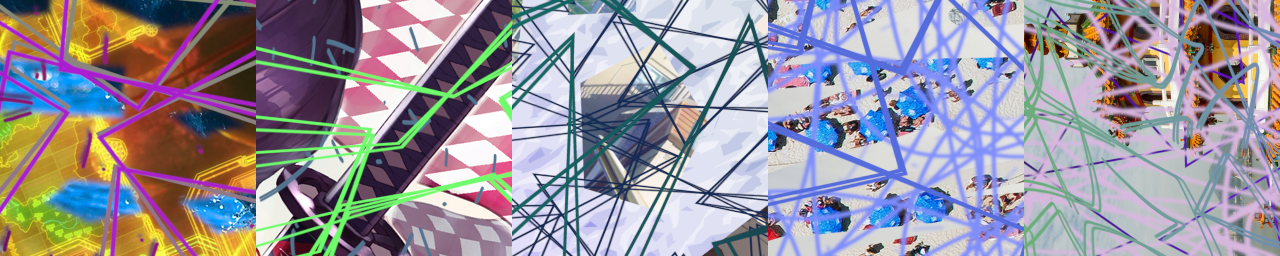

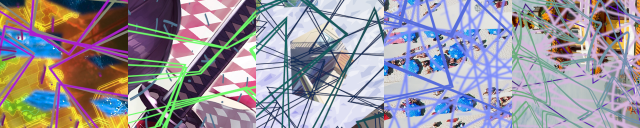

In [14]:
d_pred = next(iter(dataset_valid))
show_images(d_pred[1], val_range=[0, 1], scale=4)
show_images(d_pred[0], val_range=[0, 1], scale=8)

In [15]:
MSE_Loss = tf.keras.losses.MeanSquaredError()

def YUV_Error(y_true, y_pred):
    true_yuv = tf.image.rgb_to_yuv(y_true)
    pred_yuv = tf.image.rgb_to_yuv(y_pred)
    
    true_y, true_u, true_v = tf.split(true_yuv, 3, axis=-1)
    pred_y, pred_u, pred_v = tf.split(pred_yuv, 3, axis=-1)
        
    y_err = MSE_Loss(true_y, pred_y) * 0.5
    u_err = MSE_Loss(true_u, pred_u) * 0.25
    v_err = MSE_Loss(true_v, pred_v) * 0.25
    
    return (y_err + u_err + v_err)

In [16]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=10000.0, clipvalue=0.00000001, momentum=0.9, decay=0.0, nesterov=True), loss=YUV_Error)
model.fit(dataset_train.repeat(), epochs=1, steps_per_epoch=4096, validation_data=dataset_valid)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=YUV_Error)
model.fit(dataset_train.repeat(), epochs=1, steps_per_epoch=4096*2, validation_data=dataset_valid)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=YUV_Error)
model.fit(dataset_train.repeat(), epochs=1, steps_per_epoch=4096*2, validation_data=dataset_valid)

8192/8192 [==============================] - 156s 19ms/step - loss: 0.0030 - val_loss: 0.0011


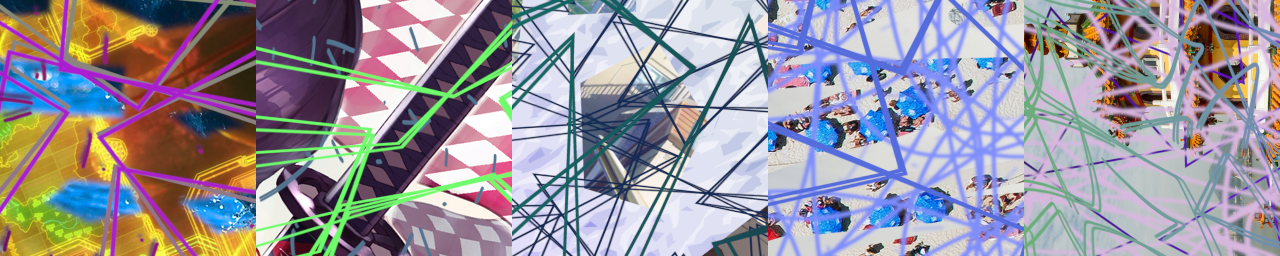

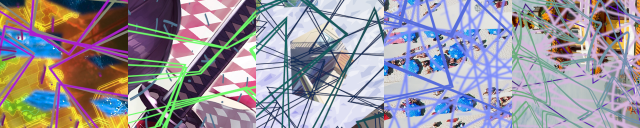

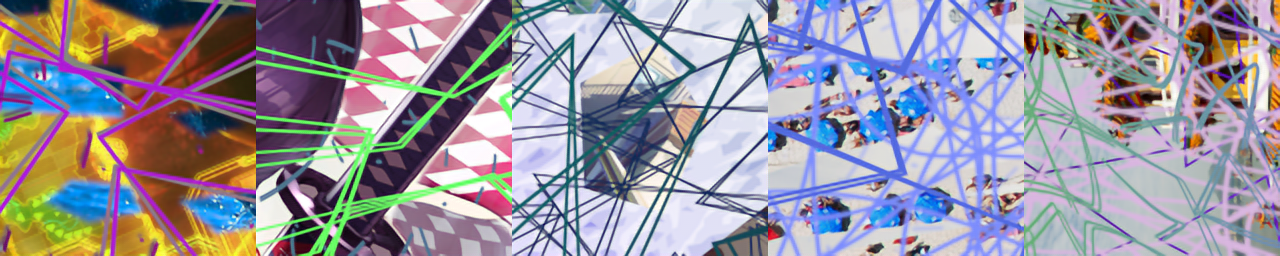

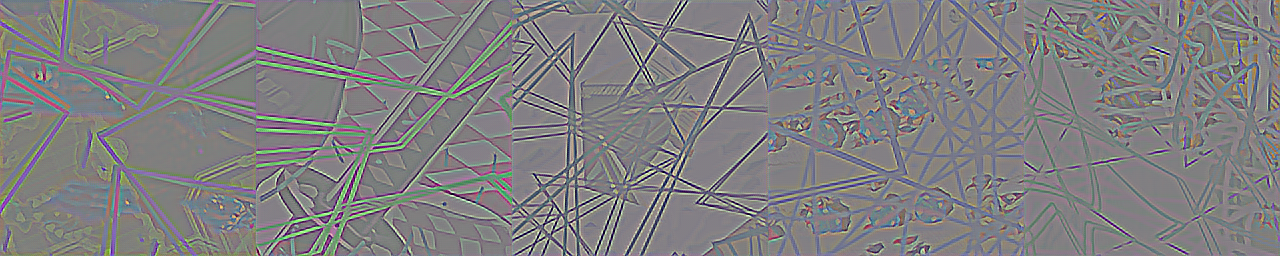

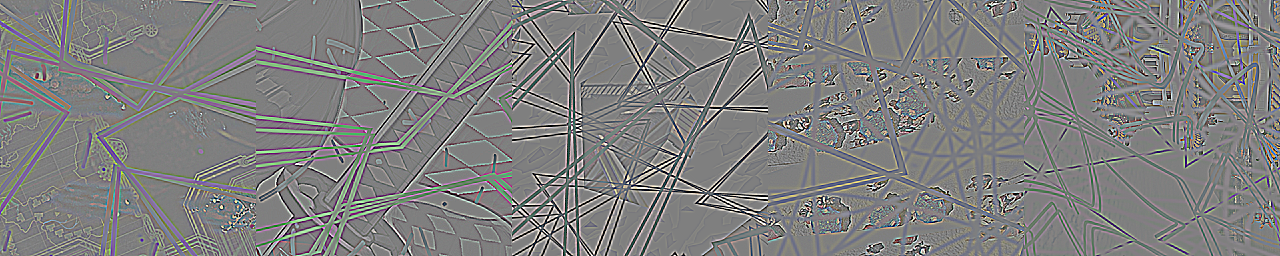

In [17]:
d_pred = next(iter(dataset_valid))
show_images(d_pred[1], val_range=[0, 1], scale=8)
show_images(d_pred[0], val_range=[0, 1], scale=8)

pred_pred = model.predict(d_pred[0])
d_pred0 =  tf.image.resize(d_pred[0], [d_pred[1].shape[1], d_pred[1].shape[2]], method="bilinear")
show_images(pred_pred, val_range=[0, 1], scale=4)
show_images(pred_pred - d_pred0, val_range=[-0.2, 0.2], scale=4)
show_images(d_pred[1] - d_pred0, val_range=[-0.2, 0.2], scale=4)

In [18]:
model.save_weights("model-checkpoint.h5")